In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Select the GPU index
import nltk
from torch.optim.lr_scheduler import _LRScheduler
import time
import math
import matplotlib.pyplot as plt
import spacy
from scipy.io import savemat
import dill as pickle
import thop

In [2]:
# Dictionary
dicno=4
dictionaries =[['AAGCGC', 'ACGAGC', 'ATGGCG', 'AGCACG', 'CAGGTG', 'CCTACG', 'CTACGC', 'CGAACG', 'TAGGGC',
                'TCGTGC', 'TTGCCG', 'TGCTCG', 'GACGAC', 'GCAGCA', 'GTAGGC', 'GGTCGA'],
               
               ['AAGCGC', 'ACGAGC', 'ATCCGC', 'ATGGCG', 'AGCACG', 'CATCCG', 'CAGGTG', 'CCTACG', 'CCTGGT',
                'CCGTTG', 'CTACGC', 'CTGGAG', 'CGAACG', 'CGGAAC', 'TAGGGC', 'TCCGCA', 'TCGTGC', 'TCGGGA',
                'TTCGGC', 'TTGCCG', 'TGCTCG', 'GACGAC', 'GATGCG', 'GCAGCA', 'GCCTAC', 'GTAGGC', 'GGACGT',
                'GGCTAG', 'GGCTTC', 'GGTAGC', 'GGTCCT', 'GGTCGA' ],
               
               ['ACTACGACA', 'ACTGACACA', 'ACGACTACA', 'ATCAGCACA', 'AGCATCACA', 'CATCAGACA', 'CAGCATACA', 
                'TACGACACA', 'GACTACACA', 'ACTACTGAG', 'ACTACGATG', 'ACTACGTAG', 'ACTACGTGA', 'ACTGACATG',
                'ACTGACTAG', 'ACTGACTGA', 'ACTGACGAT', 'ACTGACGTA', 'ACTGATACG', 'ACTGATAGC', 'ACTGATCGA', 
                'ACTGATGAC', 'ACTGATGCA', 'ACTGCTAGA', 'ACGACTATG', 'ACGACTAGT', 'ACGACTGAT', 'ACGACTGTA', 'ACGATGACT', 
                'ACGATGATC', 'ACGATGCTA', 'ACGATGTAC', 'ACGATGTCA', 'ATCATCGAG', 'ATCAGCATG', 'ATCAGCAGT', 'ATCAGCTGA', 
                'ATCAGCGTA', 'ATCAGTACG', 'ATCAGTAGC', 'ATCAGTCAG', 'ATCAGTCGA', 'ATCAGTGCA', 'ATCGTACAG', 'ATCGTACGA', 
                'ATCGTAGAC', 'ATCGTAGCA', 'ATCGTCAGA', 'ATGACTACG', 'ATGACTAGC', 'ATGACTCGA', 'ATGACTGAC', 'ATGACTGCA', 
                'ATGACGACT', 'ATGACGATC', 'ATGACGCTA', 'ATGACGTCA', 'ATGATGCAC', 'ATGCTACAG', 'ATGCTACGA', 'ATGCTAGAC', 
                'ATGCTAGCA', 'ATGCTGACA', 'AGCATCATG', 'AGCATCAGT', 'AGCATCTAG', 'AGCATCTGA', 'AGCATCGTA', 'AGCAGTACT', 
                'AGCAGTATC', 'AGCAGTCAT', 'AGCAGTCTA', 'AGTAGCATC', 'AGTAGCTAC', 'AGTAGCTCA', 'AGTAGTCAC', 'AGTCATACG', 
                'AGTCATAGC', 'AGTCATCAG', 'AGTCATCGA', 'AGTCATGCA', 'AGTCAGATC', 'AGTCAGCAT', 'AGTCAGCTA', 'AGTCAGTAC', 
                'AGTCAGTCA', 'AGTCGTACA', 'CATCAGAGT', 'CATCAGTAG', 'CATCAGTGA', 'CATCGTAGA', 'CAGCATATG', 'CAGCATAGT', 
                'CAGCATGAT', 'CAGCATGTA', 'CAGCAGTAT', 'CAGTAGATC', 'CAGTAGCAT', 'CAGTAGCTA', 'CAGTAGTAC', 'CAGTAGTCA', 
                'CAGTCATAG', 'CAGTCATGA', 'CAGTCAGAT', 'CAGTCAGTA', 'CAGTCGATA', 'CTACTGAGA', 'CTACGATGA', 'CTACGAGAT', 
                'CTACGAGTA', 'CTGACTAGA', 'CTGACGATA', 'CTGATGACA', 'CGACTATAG', 'CGACTATGA', 'CGACTAGAT', 'CGACTAGTA',
                'CGACTGATA', 'CGACGATAT', 'CGATGACTA', 'CGATGATAC', 'CGATGCATA', 'CGTAGCATA', 'CGTCATAGA', 'CGTCAGATA', 
                'TACTACGAG', 'TACTGACAG', 'TACTGACGA', 'TACTGAGAC', 'TACTGAGCA', 'TACTGCAGA', 'TACGACAGT', 'TACGACTAG',
                'TACGACTGA', 'TACGACGAT', 'TACGATACG', 'TACGATAGC', 'TACGATCAG', 'TACGATCGA', 'TACGATGAC', 'TACGATGCA', 
                'TAGCATACG', 'TAGCATAGC', 'TAGCATCAG', 'TAGCATCGA', 'TAGCATGAC', 'TAGCATGCA', 'TAGCAGACT', 'TAGCAGCAT', 
                'TAGCAGTAC', 'TAGCAGTCA', 'TAGTAGCAC', 'TAGTCACAG', 'TAGTCACGA', 'TAGTCAGAC', 'TAGTCAGCA', 'TAGTCGACA', 
                'TCATCAGAG', 'TCATCGAGA', 'TCAGCATAG', 'TCAGCAGAT', 'TCAGCAGTA', 'TCAGTACAG', 'TCAGTACGA', 'TCAGTAGAC',
                'TCAGTAGCA', 'TCAGTCAGA', 'TCGTAGACA', 'TGACTACAG', 'TGACTACGA', 'TGACTAGAC', 'TGACTAGCA', 'TGACTGACA', 
                'TGACGACAT', 'TGACGACTA', 'TGACGATAC', 'TGATGACAC', 'TGATGCACA', 'TGCTACAGA', 'GACTACATG', 'GACTACTAG', 
                'GACTACTGA', 'GACTACGAT', 'GACTACGTA', 'GACTGACAT', 'GACTGACTA', 'GACTGATAC', 'GACTGATCA', 'GACTGCATA', 
                'GACGACTAT', 'GACGATACT', 'GACGATATC', 'GACGATCAT', 'GACGATCTA', 'GATGACACT', 'GATGACTAC', 'GATGACTCA', 
                'GATGCTACA', 'GCATCATAG', 'GCATCAGAT', 'GCATCAGTA', 'GCATCGATA', 'GCAGCATAT', 'GCAGTACAT', 'GCAGTACTA', 
                'GCAGTATAC', 'GCAGTATCA', 'GCAGTCATA', 'GCTACGATA', 'GCTGACATA', 'GCTGATACA', 'GTAGCACAT', 'GTAGCACTA', 
                'GTAGCATCA', 'GTAGTCACA', 'GTCATCAGA', 'GTCAGCATA', 'GTCAGTACA', 'ACTGATGTG', 'ACGATGTGT', 'ATCAGTGTG', 
                'ATCGTAGTG', 'ATGACTGTG', 'ATGACGTGT', 'ATGATGCTG', 'ATGATGCGT', 'ATGATGTCG', 'ATGATGTGC', 'ATGCTAGTG', 
                'ATGCTGATG', 'ATGCTGAGT', 'ATGCTGTGA', 'AGTAGCTGT', 'AGTAGTCTG', 'AGTAGTCGT', 'AGTAGTGCT', 'AGTAGTGTC', 
                'AGTCATGTG', 'AGTCAGTGT', 'AGTCGTATG', 'AGTCGTAGT', 'AGTCGTGTA', 'CAGTAGTGT', 'CTGATGATG', 'CTGATGAGT', 
                'CTGATGTAG', 'CTGATGTGA', 'CGATGATGT', 'CGTAGTATG', 'CGTAGTAGT', 'CGTAGTGAT', 'CGTAGTGTA', 'TACGATGTG', 
                'TAGCATGTG', 'TAGCAGTGT'],
               
               ['ACGTAGCAGA', 'ACTACAGACG', 'AGACGATGCA', 'AGCGACTATC', 'ATAGCTCGTG', 'CACGAGCTAT','CGTCTGTAGT',
                'CTATCAGCGA', 'GATAGTCGCT', 'GCAGACATCA', 'GTGCTCGATA', 'TATCGAGCAC', 'TCGCTGATAG', 'TCTGCTACGT',
                'TGATGTCTGC', 'TGCATCGTCT'],
               
               ['ATCGATCGATCGAT','TACGTAGCTAGCTA', 'TAGCTACGTAGCTA', 'ATGCATGCATCGAT', 'ATGCTACGATGCTA', 
                'TAGCATGCTACGAT', 'TACGATCGTACGAT', 'ATCGTAGCATGCTA', 'TACGATGCTAGCAT', 'ATCGTACGATCGTA', 
                'ATGCTAGCATCGTA', 'TAGCATCGTAGCAT', 'TAGCTAGCTACGTA', 'ATGCATCGATGCAT', 'ATCGATGCATGCAT', 
                'TACGTACGTACGTA'],
              
               ['ATCGATCG', 'ATCGATGC', 'ATCGTAGC', 'ATCGTACG', 'ATGCTAGC', 'ATGCTACG', 'ATGCATCG', 'ATGCATGC',
                'TAGCTAGC', 'TAGCTACG', 'TAGCATCG', 'TAGCATGC', 'TACGATCG', 'TACGATGC', 'TACGTAGC', 'TACGTACG']
              
               ]
dicts=dictionaries[dicno]
print(dicts)

['ATCGATCGATCGAT', 'TACGTAGCTAGCTA', 'TAGCTACGTAGCTA', 'ATGCATGCATCGAT', 'ATGCTACGATGCTA', 'TAGCATGCTACGAT', 'TACGATCGTACGAT', 'ATCGTAGCATGCTA', 'TACGATGCTAGCAT', 'ATCGTACGATCGTA', 'ATGCTAGCATCGTA', 'TAGCATCGTAGCAT', 'TAGCTAGCTACGTA', 'ATGCATCGATGCAT', 'ATCGATGCATGCAT', 'TACGTACGTACGTA']


In [3]:
batch_size=2000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr=0.001
num_epochs=500
final_num_epochs=200
patience=400
train_num_samples=30000
test_num_samples=10000
final_train_num_samples=500000
final_test_num_samples=10000
num_errors=4
K=len(dicts[0])
hidden_size=32

In [4]:
path_directory=f"finalmodels/BiLSTM/Dictionary_{dicno}/batch_size_{batch_size}/num_errors_{num_errors}/initial_lr_{lr}/epochs{final_num_epochs}_p{patience}_tr{final_train_num_samples}ts{final_test_num_samples}K{K}hs{hidden_size}/"
path_directory

'finalmodels/BiLSTM/Dictionary_4/batch_size_2000/num_errors_4/initial_lr_0.001/epochs200_p400_tr500000ts10000K14hs32/'

In [5]:
# Check if "models" folder exists, create it if it doesn't
if not os.path.exists(path_directory):
    os.makedirs(path_directory)

In [6]:
class BiLSTMDeletionModel(nn.Module):

    def __init__(self, hidden_size, dropout):
        super().__init__()
        
        self.lstm1 = nn.LSTM(
            input_size=5, 
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2*hidden_size, 4)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):

        # BiLSTM 1
        out, _ = self.lstm1(x)
        out = self.softmax(self.fc(out))
        return out

In [7]:
deletion_model = BiLSTMDeletionModel(hidden_size,0.1)

In [8]:
deletion_path_directory=f"deletionmodels/BiLSTM/Dictionary_{dicno}/batch_size_{batch_size}/num_errors_{num_errors}/initial_lr_{lr}/epochs{num_epochs}_p{patience}_tr{train_num_samples}ts{test_num_samples}K{K}hs{hidden_size}/"
deletion_path_directory

'deletionmodels/BiLSTM/Dictionary_4/batch_size_2000/num_errors_4/initial_lr_0.001/epochs500_p400_tr30000ts10000K14hs32/'

In [9]:
deletion_model.load_state_dict(torch.load(deletion_path_directory+"model.pth"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params'])

In [10]:
class BiLSTMsubstitutionModel(nn.Module):

    def __init__(self, hidden_size, dropout):
        super().__init__()
        
        self.lstm1 = nn.LSTM(
            input_size=4, 
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2*hidden_size, 4)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):

        # BiLSTM 1
        out, _ = self.lstm1(x)
        out = self.softmax(self.fc(out))
        return out

In [11]:
substitution_model = BiLSTMsubstitutionModel(hidden_size,0.1)

In [12]:
substitution_path_directory=f"substitutionmodels/BiLSTM/Dictionary_{dicno}/batch_size_{batch_size}/num_errors_{num_errors}/initial_lr_{lr}/epochs{num_epochs}_p{patience}_tr{train_num_samples}ts{test_num_samples}K{K}hs{hidden_size}/"
substitution_path_directory

'substitutionmodels/BiLSTM/Dictionary_4/batch_size_2000/num_errors_4/initial_lr_0.001/epochs500_p400_tr30000ts10000K14hs32/'

In [13]:
substitution_model.load_state_dict(torch.load(substitution_path_directory+"model.pth"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params'])

In [14]:
class BiLSTMinsertionModel(nn.Module):

    def __init__(self, hidden_size, dropout):
        super().__init__()
        
        self.lstm1 = nn.LSTM(
            input_size=5, 
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2*hidden_size, 5)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):

        # BiLSTM 1
        out, _ = self.lstm1(x)
        out = self.softmax(self.fc(out))
        return out

In [15]:
insertion_model = BiLSTMinsertionModel(hidden_size,0.1)

In [16]:
insertion_path_directory=f"insertionmodels/BiLSTM/Dictionary_{dicno}/batch_size_{batch_size}/num_errors_{num_errors}/initial_lr_{lr}/epochs{num_epochs}_p{patience}_tr{train_num_samples}ts{test_num_samples}K{K}hs{hidden_size}/"
insertion_path_directory

'insertionmodels/BiLSTM/Dictionary_4/batch_size_2000/num_errors_4/initial_lr_0.001/epochs500_p400_tr30000ts10000K14hs32/'

In [17]:
insertion_model.load_state_dict(torch.load(insertion_path_directory+"model.pth"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params'])

In [18]:
insertion_model.to(device)
substitution_model.to(device)
deletion_model.to(device)

BiLSTMDeletionModel(
  (lstm1): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=2)
)

In [19]:
class BiLSTMcombinerModel(nn.Module):

    def __init__(self, hidden_size, dropout):
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=4, 
            hidden_size=5*hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(10*hidden_size, 5)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):
        # BiLSTM 1
        out, _ = self.lstm1(x)
        out = self.softmax(self.fc(out))
        return out

In [20]:
combiner_model=BiLSTMcombinerModel(hidden_size,0.1)

In [21]:
class ParallelEnsemble(nn.Module):
    def __init__(self, insertion_model, deletion_model, substitution_model, combiner_model):
        super().__init__()
        self.insert_model = insertion_model 
        self.delete_model = deletion_model
        self.subst_model = substitution_model
        self.combiner_model = combiner_model
        
        # Freeze insertion, deletion, substitution models
        for param in self.insert_model.parameters():
            param.requires_grad = False

        for param in self.delete_model.parameters():
            param.requires_grad = False

        for param in self.subst_model.parameters():
            param.requires_grad = False

        # Ensure combiner model is trainable
        for param in self.combiner_model.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Get predictions in parallel 
        insert_in = one_hot_encode(x.to(device), 5)
        insert_out = self.insert_model(insert_in)  
        delete_in = one_hot_encode(x[:,:K].to(device), 5)
        delete_out = self.delete_model(delete_in)
        subst_in = one_hot_encode(x[:,:K].to(device), 5)
        subst_out = self.subst_model(subst_in[:,:,:4])
        # Combine parallel outputs  
        combined_out = torch.cat([insert_out[:,:K,:4], delete_out[:,:K,:4], subst_out[:,:K,:4]], dim=1)
        # Final correction  
        y = self.combiner_model(combined_out)
        return y

ensemble = ParallelEnsemble(insertion_model, deletion_model, substitution_model, combiner_model).to(device)

In [22]:
def one_hot_encode(sequences, n_unique):

    # Get size of batch and max sequence length
    batch_size,seq_len=sequences.shape
    #len(sequences)
    #seq_len=len(sequences[0])
    
    # Initialize encoded tensor
    oneencoding = torch.zeros(batch_size, seq_len, n_unique, device = device)
    # Set 1 at index of each character
    for i in range(batch_size):
        for j in range(seq_len):
            index = sequences[i][j]
            oneencoding[i, j, index] = 1          
    return oneencoding

In [23]:
def one_hot_decode(encoded_seq):
    """Converts a batch of one-hot encoded sequences to indices"""
    
    # Dimensions will be (batch_size, seq_len, num_classes)
    batch_size, seq_len, num_classes = encoded_seq.shape
    
    # Flatten to treat as a list of one-hot vectors
    encoded_seq = encoded_seq.reshape(-1, num_classes)
    
    # Argmax over classes to get class index
    indices = encoded_seq.argmax(dim=1).to(device)
    
    # Reshape back to original dimensions
    indices = indices.reshape(batch_size, seq_len)
    
    return indices

In [24]:
class LanguageDataset1(Dataset):

    def __init__(self, dictionary, num_samples, num_errors):
        self.dictionary = dictionary
        self.num_samples = num_samples 
        self.num_errors = num_errors

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        source_idx = idx % len(self.dictionary)
        sequence = self.dictionary[source_idx]
        choice = torch.rand(1).item()
        if self.num_errors > 0:
            if choice >= 0 and choice< 0.10646:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                for _ in range(self.num_errors):
                    sequence.append('N')  
                sequence=''.join(sequence)
                #sequence= torch.cat([sequence, 'NNNN'], dim=1)
            elif choice >=0.10646 and choice < 0.14218:
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                for _ in range(self.num_errors):
                    sequence.append('N') 
                sequence=''.join(sequence)
                #sequence= torch.cat([sequence, 'NNNN'], dim=1)
            elif choice >=0.14218 and choice < 0.15163:
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
            elif choice >=0.15163 and choice < 0.156:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                for _ in range(self.num_errors):
                    sequence.append('N') 
                sequence=''.join(sequence)
                #sequence= torch.cat([sequence, 'NNNN'], dim=1)
            elif choice >=0.156 and choice < 0.15701:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                
            elif choice >=0.15701 and choice < 0.1574:
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
            elif choice >=0.1574 and choice < 0.15747:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)  
            else:
                sequence = list(sequence)
                for _ in range(self.num_errors):
                    sequence.append('N') 
                sequence=''.join(sequence) 
            
        x = torch.tensor([self.char_to_idx(c) for c in sequence], dtype=torch.long)
        y = torch.tensor([self.char_to_idx(c) for c in self.dictionary[source_idx]], dtype=torch.long)
        return x.to(device), y.to(device)

    def introduce_deletion_errors(self, sequence, num_errors):
        ne = random.randint(1, num_errors)
        sequence = list(sequence)
        
        for _ in range(ne):
            i = random.randint(0, len(sequence)-1)
            del sequence[i]
            sequence.append('N') 
        
        return sequence
    
    def introduce_substitution_errors(self, sequence, num_errors):
        ne = random.randint(1, num_errors)
        sequence = list(sequence)
        for _ in range(ne):
            i = random.randint(0, len(sequence)-1)
            if sequence[i] == 'A':
                sequence[i] = random.choice(['T', 'G', 'C'])
            elif sequence[i] == 'T':
                sequence[i] = random.choice(['A', 'G', 'C'])
            elif sequence[i] == 'G':
                sequence[i] = random.choice(['A', 'T', 'C'])
            elif sequence[i] == 'C':
                sequence[i] = random.choice(['A', 'T', 'G'])
        
        return sequence
    
    def introduce_insertion_errors(self, sequence, num_errors):
        ne = random.randint(1, num_errors)
        sequence = list(sequence)
        for _ in range(num_errors-ne):
            sequence.append('N')
        for _ in range(ne):
            i = random.randint(0, len(sequence))
            random_char = random.choice(['A','C','T','G']) 
            sequence.insert(i, random_char)
        return sequence

    def char_to_idx(self, char):
        return {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4}[char]

In [25]:
train_data = LanguageDataset1(dicts, num_samples=final_train_num_samples, num_errors=num_errors)
test_data = LanguageDataset1(dicts, num_samples=final_test_num_samples, num_errors=num_errors)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [26]:
criterion= nn.MSELoss().to(device)
optimizer = torch.optim.Adam(ensemble.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

In [27]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

In [28]:
scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                            T_max=final_num_epochs * len(train_loader),
                                            T_warmup=50 * len(train_loader),
                                            eta_min=1e-6)

In [29]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []
patience_counter = 0
best_val_loss = float('inf')

for i in range(final_num_epochs):
    loss1 = 0
    epoch_time = time.time()
    ensemble.train()
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):  
        optimizer.zero_grad()
        # Apply the model
        #xt=one_hot_encode(X_train.to(device), 5)
        y_pred=ensemble(X_train)
        #print(y_pred.shape)
        y_train = torch.cat([y_train, 4*torch.ones(batch_size, 2*K, dtype=torch.int).to(device)], dim=1)
        yt=one_hot_encode(y_train, 5).to(device)
        loss = criterion(y_pred, yt) 
        # Update parameters
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss1=loss1+loss
        #if (b+1)%50==1:
        #    print(f'epoch: {i+1}/{num_epochs} batch:{b+1}/{num_train_batches} loss: {loss.item():10.8f}')      
    train_loss=loss1/num_train_batches  
    train_losses.append(train_loss.item())
    # Run the testing batches
    ensemble.eval()
    with torch.no_grad():
        loss1=0
        for b, (X_test, y_test) in enumerate(test_loader):
            
            # Apply the model
            #xt=one_hot_encode(X_test.to(device), 5)
            y_pred=ensemble(X_test)
            y_test = torch.cat([y_test, 4*torch.ones(batch_size, 2*K, dtype=torch.int).to(device)], dim=1)
            yt=one_hot_encode(y_test, 5).to(device)
            loss = criterion(y_pred, yt) 
            loss1=loss1+loss         
        val_loss=loss1/num_test_batches  
        val_losses.append(val_loss.item())
    
    print(f'epoch:{i+1}/{final_num_epochs} average TL:{train_loss.item():10.8f} average VL:{val_loss.item():10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
     # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(ensemble.state_dict(), path_directory+"model.pth")
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/200 average TL:0.15571301 average VL:0.14213748 epoch time:1568 seconds, lr:2.00e-05
epoch:2/200 average TL:0.09038997 average VL:0.05957448 epoch time:1567 seconds, lr:4.00e-05
epoch:3/200 average TL:0.05159331 average VL:0.04749041 epoch time:1563 seconds, lr:6.00e-05
epoch:4/200 average TL:0.04378421 average VL:0.03577872 epoch time:1565 seconds, lr:8.00e-05
epoch:5/200 average TL:0.01630315 average VL:0.00304481 epoch time:1562 seconds, lr:1.00e-04
epoch:6/200 average TL:0.00265089 average VL:0.00240604 epoch time:1564 seconds, lr:1.20e-04
epoch:7/200 average TL:0.00255339 average VL:0.00230109 epoch time:1566 seconds, lr:1.40e-04
epoch:8/200 average TL:0.00243466 average VL:0.00226344 epoch time:1562 seconds, lr:1.60e-04
epoch:9/200 average TL:0.00208864 average VL:0.00162911 epoch time:1565 seconds, lr:1.80e-04
epoch:10/200 average TL:0.00148836 average VL:0.00130597 epoch time:1565 seconds, lr:2.00e-04
epoch:11/200 average TL:0.00124649 average VL:0.00112372 epoch time:1

epoch:89/200 average TL:0.00044183 average VL:0.00039944 epoch time:1562 seconds, lr:8.42e-04
epoch:90/200 average TL:0.00043740 average VL:0.00042936 epoch time:1564 seconds, lr:8.35e-04
epoch:91/200 average TL:0.00043547 average VL:0.00039472 epoch time:1566 seconds, lr:8.27e-04
epoch:92/200 average TL:0.00043441 average VL:0.00042944 epoch time:1566 seconds, lr:8.19e-04
epoch:93/200 average TL:0.00043820 average VL:0.00047516 epoch time:1566 seconds, lr:8.11e-04
epoch:94/200 average TL:0.00043289 average VL:0.00046031 epoch time:1569 seconds, lr:8.02e-04
epoch:95/200 average TL:0.00042937 average VL:0.00042940 epoch time:1573 seconds, lr:7.94e-04
epoch:96/200 average TL:0.00043192 average VL:0.00039875 epoch time:1579 seconds, lr:7.86e-04
epoch:97/200 average TL:0.00043475 average VL:0.00047519 epoch time:1579 seconds, lr:7.77e-04
epoch:98/200 average TL:0.00042691 average VL:0.00048623 epoch time:1601 seconds, lr:7.68e-04
epoch:99/200 average TL:0.00042428 average VL:0.00040727 epo

epoch:176/200 average TL:0.00037078 average VL:0.00034678 epoch time:1544 seconds, lr:6.28e-05
epoch:177/200 average TL:0.00037936 average VL:0.00034020 epoch time:1536 seconds, lr:5.78e-05
epoch:178/200 average TL:0.00037099 average VL:0.00039227 epoch time:1536 seconds, lr:5.31e-05
epoch:179/200 average TL:0.00036307 average VL:0.00037800 epoch time:1542 seconds, lr:4.85e-05
epoch:180/200 average TL:0.00036843 average VL:0.00036316 epoch time:1749 seconds, lr:4.42e-05
epoch:181/200 average TL:0.00036215 average VL:0.00038435 epoch time:1563 seconds, lr:4.00e-05
epoch:182/200 average TL:0.00036802 average VL:0.00035933 epoch time:1547 seconds, lr:3.61e-05
epoch:183/200 average TL:0.00036620 average VL:0.00040208 epoch time:1539 seconds, lr:3.23e-05
epoch:184/200 average TL:0.00036880 average VL:0.00033900 epoch time:1537 seconds, lr:2.88e-05
epoch:185/200 average TL:0.00037360 average VL:0.00033954 epoch time:1536 seconds, lr:2.54e-05
epoch:186/200 average TL:0.00037069 average VL:0.0

In [30]:
t1=iter(train_loader)
X,y=next(t1)
flops, params = thop.profile(ensemble, inputs=(X,), verbose=False)
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')

Model Flops: 73579256000.0
Model Params Num: 936850.0



In [31]:
dict={'train_losses':train_losses, 'val_losses':val_losses, 'flops':flops, 'parameters':params }
savemat(path_directory+'losses.mat', dict)
with open(path_directory+'losses.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict, file)

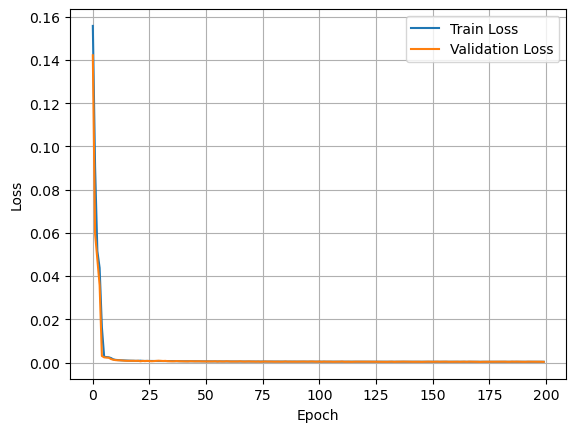

In [32]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [33]:
class LanguageDataset(Dataset):

    def __init__(self, dictionary, num_samples, num_errors):
        self.dictionary = dictionary
        self.num_samples = num_samples 
        self.num_errors = num_errors

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        source_idx = idx % len(self.dictionary)
        sequence = self.dictionary[source_idx]
        choice = torch.rand(1).item()
        if self.num_errors > 0:
            if choice >= 0 and choice< 0.10646:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                for _ in range(self.num_errors):
                    sequence.append('N')  
                sequence=''.join(sequence)
                #sequence= torch.cat([sequence, 'NNNN'], dim=1)
            elif choice >=0.10646 and choice < 0.14218:
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                for _ in range(self.num_errors):
                    sequence.append('N') 
                sequence=''.join(sequence)
                #sequence= torch.cat([sequence, 'NNNN'], dim=1)
            elif choice >=0.14218 and choice < 0.15163:
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
            elif choice >=0.15163 and choice < 0.156:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                for _ in range(self.num_errors):
                    sequence.append('N') 
                sequence=''.join(sequence)
                #sequence= torch.cat([sequence, 'NNNN'], dim=1)
            elif choice >=0.156 and choice < 0.15701:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                
            elif choice >=0.15701 and choice < 0.1574:
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
            elif choice >=0.1574 and choice < 0.15747:
                sequence = self.introduce_substitution_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_deletion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)
                sequence = self.introduce_insertion_errors(sequence, self.num_errors)
                sequence=''.join(sequence)  
            else:
                sequence = list(sequence)
                for _ in range(self.num_errors):
                    sequence.append('N') 
                sequence=''.join(sequence)   
            
        x = torch.tensor([self.char_to_idx(c) for c in sequence], dtype=torch.long)
        y = torch.tensor([self.char_to_idx(c) for c in self.dictionary[source_idx]], dtype=torch.long)
        return x.to(device), y.to(device)

    def introduce_deletion_errors(self, sequence, num_errors):
        #ne = random.randint(1, num_errors)
        sequence = list(sequence)
        
        for _ in range(num_errors):
            i = random.randint(0, len(sequence)-1)
            del sequence[i]
            sequence.append('N') 
        
        return sequence
    
    def introduce_substitution_errors(self, sequence, num_errors):
        #ne = random.randint(1, num_errors)
        sequence = list(sequence)
        for _ in range(num_errors):
            i = random.randint(0, len(sequence)-1)
            if sequence[i] == 'A':
                sequence[i] = random.choice(['T', 'G', 'C'])
            elif sequence[i] == 'T':
                sequence[i] = random.choice(['A', 'G', 'C'])
            elif sequence[i] == 'G':
                sequence[i] = random.choice(['A', 'T', 'C'])
            elif sequence[i] == 'C':
                sequence[i] = random.choice(['A', 'T', 'G'])
        
        return sequence
    
    def introduce_insertion_errors(self, sequence, num_errors):
        #ne = random.randint(1, num_errors)
        sequence = list(sequence)
        #for _ in range(num_errors-ne):
        #    sequence.append('N')
        for _ in range(num_errors):
            i = random.randint(0, len(sequence))
            random_char = random.choice(['A','C','T','G']) 
            sequence.insert(i, random_char)
        return sequence

    def char_to_idx(self, char):
        return {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4}[char]

In [34]:
start_test=1
stop_test=4
num_test=200000
test_error_points=torch.arange(start_test, stop_test+1)
#nucleotide error rate
ner=torch.zeros((stop_test-start_test+1)).to(device)
#sequence error rate
ser=torch.zeros((stop_test-start_test+1)).to(device)
time_tensor =torch.zeros((stop_test-start_test+1)).to(device)

In [35]:
def count_different_rows(matrix1, matrix2):
    """
    Calculates the number of rows that are not equal between two 2D PyTorch matrices.

    Args:
        matrix1 (torch.Tensor): A 2D PyTorch tensor of shape (m, n).
        matrix2 (torch.Tensor): A 2D PyTorch tensor of shape (m, n).

    Returns:
        int: The number of rows that are not equal between the two matrices.
    """
    assert matrix1.shape == matrix2.shape, "The input matrices must have the same shape."
    equal_rows = torch.all(matrix1 == matrix2, dim=1)
    return matrix1.shape[0] - torch.sum(equal_rows).item()

In [36]:
i1=0
for i in range(start_test, stop_test+1):
    test_data1 = LanguageDataset(dicts, num_samples=num_test, num_errors=i)
    test_loader1 = DataLoader(test_data1, batch_size=batch_size, shuffle=True)
    n_tbatch=len(test_loader1)
    ne=0.0
    count=0.0
    decoding_time =0
    # Run the testing batches
    ensemble.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader1):
            # Apply the model
            start_time = time.time()
            y_pred=ensemble(X_test)
            decoding_time = decoding_time + time.time()-start_time
            y_pred_d=one_hot_decode(y_pred)
            
            y_pred_dk = y_pred_d[:,:K]
            ne=ne+torch.sum(y_pred_dk!=y_test).item()
            count=count+count_different_rows(y_test,y_pred_dk)
        time_tensor[i1] = decoding_time/(n_tbatch*batch_size)
        ner[i1]=ne/(n_tbatch*batch_size*K)
        ser[i1]=count/(n_tbatch*batch_size)
    i1=i1+1

In [37]:
time_tensor

tensor([0.0014, 0.0014, 0.0014, 0.0015], device='cuda:0')

In [38]:
ner

tensor([0.0012, 0.0031, 0.0065, 0.0097], device='cuda:0')

In [39]:
ser

tensor([0.0074, 0.0152, 0.0315, 0.0451], device='cuda:0')

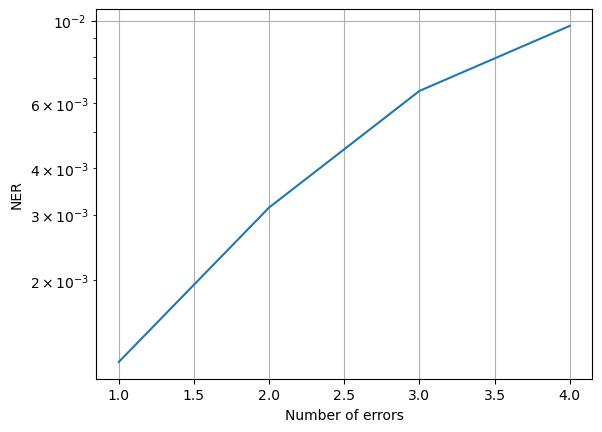

In [40]:
plt.plot(torch.Tensor.cpu(test_error_points).numpy(),torch.Tensor.cpu(ner).numpy())
plt.yscale('log')
plt.xlabel('Number of errors')
plt.ylabel('NER')    
plt.grid(True)
plt.show()

In [41]:
dict1={'ner':torch.Tensor.cpu(ner).numpy(), 'ser':torch.Tensor.cpu(ser).numpy()}
savemat(path_directory+'metric.mat', dict1)
with open(path_directory+'metric.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict1, file)

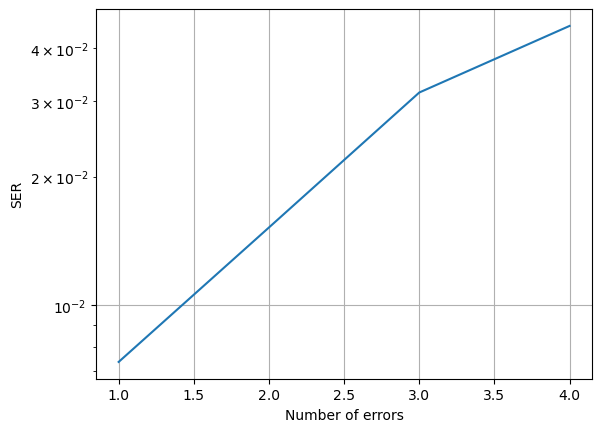

In [42]:
plt.plot(torch.Tensor.cpu(test_error_points).numpy(),torch.Tensor.cpu(ser).numpy())
plt.yscale('log')
plt.xlabel('Number of errors')
plt.ylabel('SER')    
plt.grid(True)
plt.show()